In [52]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, roc_curve, auc
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from torch.utils.data import DataLoader
from pandas import DataFrame
from torch import Tensor

In [53]:
def load_data(dataset:int): 
    """
    loads data into pd dataFrame. either original or pca

    Args:
        dataset (int): 0 = original data, 1 = PCA data
    """

    data_orig = pd.read_csv(filepath_or_buffer='final_data_only_tpm.csv')

    data_pca = pd.read_csv(filepath_or_buffer='pca_data.csv')
    data_pca.drop(data_pca.columns[0], axis=1, inplace=True)

    # choose dataset according to user input (parameter dataset)
    if dataset==0:
        print("  loading original data")
        data = data_orig 
    else: 
        print("  loading pca data")
        data = data_pca

    # change ctargel col "cancer_type" from string label to int val
    map = {
        "kidney chromophobe": 0,
        "kidney renal papillary cell carcinoma": 1,
        "kidney renal clear cell carcinoma": 2,
    }
    data1 = data.copy()
    data1['cancer_type'] = data1['cancer_type'].replace(map)
    
    return data1

# Step 1 Loading data
print("Step 1: Loading data")

# load anyway
#data = load_data(0)

# load if necessary
try:
    data                 # its ok that this var is not defined 
except NameError:
    data = load_data(0)

data.head()

Step 1: Loading data


,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,AC092910.4,AC073611.1,AC136977.1,AC078856.1,AC008763.4,AL592295.6,AC006486.3,AL391628.1,AP006621.6,cancer_type
0,19.7011,0.1125,46.1397,1.8913,0.2670,18.6466,4.3945,24.1591,6.7242,9.4371,...,0.0,0.0641,0.0,1.0888,0.0,3.1977,0.0,0.0104,0.3953,0
1,31.6275,0.0000,45.5189,2.8743,0.4744,4.2348,1.4145,60.8153,15.4309,7.5267,...,0.0,0.0781,0.0,0.0000,0.0,15.4262,0.0,0.0042,0.4094,0
2,35.9928,0.5207,108.0270,4.8134,0.8010,4.5446,3.2850,33.1630,13.1085,12.1888,...,0.0,0.1049,0.0,0.0000,0.0,13.2312,0.0,0.1154,0.3050,0
3,18.2605,0.0921,27.5398,2.3258,0.3473,4.5023,1.5078,47.2006,10.6721,5.0657,...,0.0,0.1193,0.0,0.0000,0.0,6.4516,0.0,0.0141,0.1416,0
4,68.8052,3.4134,88.0619,6.2415,1.2251,9.5310,30.6990,66.3841,12.9370,20.1289,...,0.0,0.1141,0.0,0.0000,0.0,21.8857,0.0,0.0394,0.3547,0


In [54]:
# Step 3: Define Variables
print("Step 3: Define Variables")

HIDDEN_UNITS = 64
NUM_FEATURES = data.shape[1]-1              # pca=1028 orig=60660 # -1 because of target col
NUM_CLASSES = len(data.iloc[:,-1].unique()) # cancer types
DEVICE = "cpu"
LR = 0.0005                                 # learning Rate
EPOCHS = 50
SEED = None #42                             # set to None after debugging

loss_fn = nn.CrossEntropyLoss()             # = criterion

def accuracy_fn(y_true, y_logits):
    _, predicted = torch.max(y_logits, 1)# go from logits -> prediction probabilities -> prediction labels
    correct = (predicted == y_true).sum().item()
    accuracy = correct / y_true.size(0)
    return accuracy

print("  HIDDEN_UNITS: ", HIDDEN_UNITS)
print("  NUM_FEATURES: ", NUM_FEATURES)
print("  NUM_CLASSES: ", NUM_CLASSES)
print("  DEVICE: ", DEVICE)
print("  LR: ", LR)
print("  EPOCHS: ", EPOCHS)
print("  SEED: ", SEED)

Step 3: Define Variables
  HIDDEN_UNITS:  64
  NUM_FEATURES:  60660
  NUM_CLASSES:  3
  DEVICE:  cpu
  LR:  0.0005
  EPOCHS:  50
  SEED:  None


In [55]:
def split_data(data: DataFrame, normalize=False, seed:int=None) -> tuple[Tensor, Tensor, Tensor, Tensor]:
    """
    returns Train Test splittet Tensors

    Args:
        data (pd Dataframe): whole dataset

    Returns:
        torch tensor: 4-tuple of train test data
    """

    """
    # Split the data into training and validation sets
    train_dataset, test_dataset = train_test_split(data, test_size=0.2, random_state=seed)

    # dataloader
    batch_size = 128
    train_dataloader = DataLoader(
        dataset=train_dataset, batch_size=batch_size, shuffle=True
    )
    val_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size)
    """
    # or

    # Split the data into features (X) and target variable (y)
    X = data.drop('cancer_type', axis=1)
    y = data['cancer_type']

    X_train_pd, X_test_pd, y_train_pd, y_test_pd = train_test_split(X, y, test_size=0.2, random_state=seed)

    # normalizing data: no effect for pca
    if normalize:
        scaler = StandardScaler()
        X_train_pd = pd.DataFrame(scaler.fit_transform(X_train_pd))
        X_test_pd = pd.DataFrame(scaler.transform(X_test_pd))

    X_train_tens = torch.tensor(X_train_pd.values).float()
    X_test_tens = torch.tensor(X_test_pd.values).float()
    y_train_tens = torch.tensor(y_train_pd.values)
    y_test_tens = torch.tensor(y_test_pd.values)

    return (X_train_tens, X_test_tens, y_train_tens, y_test_tens)

# Step 2 Splitting data & formatting to tensor
print("Step 2: Splitting data & formatting to tensor")

X_train, X_test, y_train, y_test = split_data(data, normalize=True, seed=SEED)

# Print the shapes of the datasets
print("  X_train:", X_train.shape)
print("  X_test:", X_test.shape)
print("  y_train:", y_train.shape)
print("  y_test:", y_test.shape)


Step 2: Splitting data & formatting to tensor


  X_train: torch.Size([822, 60660])
  X_test: torch.Size([206, 60660])
  y_train: torch.Size([822])
  y_test: torch.Size([206])


In [56]:
# Step 4: Define the Neural Network Class
print("Step 4: Define the Neural Network Class")

class SimpleClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SimpleClassifier, self).__init__()

        # if several layers are defined here, comment-out all unused ones when using SEED 

        """
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_size, out_features=hidden_size),
            nn.ReLU(), 
            nn.Dropout(0.5),
            #nn.Linear(in_features=hidden_units, out_features=hidden_units),
            #nn.ReLU(),
            nn.Linear(in_features=hidden_size, out_features=num_classes),
            nn.Softmax(dim=1)
        )
        """

        self.non_linear_layer_stack = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_classes),
            nn.Softmax(dim=1)
        )

        """kernel_size = 3
        n_filters = 32
        conv_out_len = num_classes - kernel_size + 1
        self.convolutional_layer_stack = nn.Sequential(
            nn.Conv1d(
                in_channels=input_size,
                out_channels=hidden_size,
                kernel_size=kernel_size,
            ),
            nn.ReLU(inplace=True),
            nn.Flatten(),
            nn.Linear(in_features=n_filters * conv_out_len, out_features=num_classes),
        )"""
        
    def forward(self, x):
        # Define forward pass
        return self.non_linear_layer_stack(x)
    

# Step 5: Initialize the Neural Network
print("Step 5: Initialize the Neural Network\n")

if SEED:
    torch.manual_seed(SEED)

model = SimpleClassifier(NUM_FEATURES, HIDDEN_UNITS, NUM_CLASSES)
print("Neural Network Architecture:")
print(model)

Step 4: Define the Neural Network Class
Step 5: Initialize the Neural Network

Neural Network Architecture:
SimpleClassifier(
  (non_linear_layer_stack): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=60660, out_features=64, bias=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=3, bias=True)
    (4): Softmax(dim=1)
  )
)


In [57]:
# Step 6: Define Optimizer
print("Step 6: Define Optimizer")

optimizer = optim.Adam(model.parameters(), lr=LR)
print("optimizer: ", optimizer)

Step 6: Define Optimizer
optimizer:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0005
    maximize: False
    weight_decay: 0
)


In [58]:
## model pre testing

def model_pre_testing(DEVICE, NUM_CLASSES, X_test, X_train):
    # Perform a single forward pass on the data 
    print(model(X_train.to(DEVICE))[:5])
    print(model(X_train.to(DEVICE))[0].shape, NUM_CLASSES , "\n")

    # Make prediction logits with model
    y_logits_test = model(X_test.to(DEVICE))

    # Perform softmax calculation on logits across dimension 1 to get prediction probabilities
    y_pred_probs = torch.softmax(y_logits_test, dim=1) 
    print(y_logits_test[:5])
    print(y_pred_probs[:5], "\n")

    # Sum the first sample output of the softmax activation function 
    print(torch.sum(y_pred_probs[0]), "\n")

    # Which class does the model think is *most* likely at the index 0 sample?
    print(y_pred_probs[0])
    print(torch.argmax(y_pred_probs[0]), "\n")

#model_pre_testing(DEVICE, NUM_CLASSES, X_test, X_train)

Step 7: Training the Neural Network with Test Printing


Epoch: 1 | Loss: 1.11227, Acc: 22.75% | Test Loss: 0.79114, Test Acc: 75.73%
Epoch: 2 | Loss: 0.80457, Acc: 75.30% | Test Loss: 0.73729, Test Acc: 80.10%
Epoch: 3 | Loss: 0.72406, Acc: 82.36% | Test Loss: 0.71801, Test Acc: 83.01%
Epoch: 4 | Loss: 0.70142, Acc: 84.79% | Test Loss: 0.71137, Test Acc: 83.98%
Epoch: 5 | Loss: 0.67645, Acc: 86.98% | Test Loss: 0.70825, Test Acc: 83.98%
Epoch: 6 | Loss: 0.66254, Acc: 88.69% | Test Loss: 0.71038, Test Acc: 83.50%
Epoch: 7 | Loss: 0.65857, Acc: 89.42% | Test Loss: 0.70732, Test Acc: 83.01%
Epoch: 8 | Loss: 0.65352, Acc: 89.66% | Test Loss: 0.69933, Test Acc: 84.47%
Epoch: 9 | Loss: 0.64949, Acc: 90.15% | Test Loss: 0.69448, Test Acc: 84.95%
Epoch: 10 | Loss: 0.64749, Acc: 90.27% | Test Loss: 0.69248, Test Acc: 85.44%
Epoch: 20 | Loss: 0.62259, Acc: 92.58% | Test Loss: 0.68567, Test Acc: 85.44%
Epoch: 30 | Loss: 0.60489, Acc: 94.53% | Test Loss: 0.67790, Test Acc: 87.38%
Epoch: 40 | Loss: 0.58859, Acc: 96.35% | Test Loss: 0.65106, Test Acc: 89

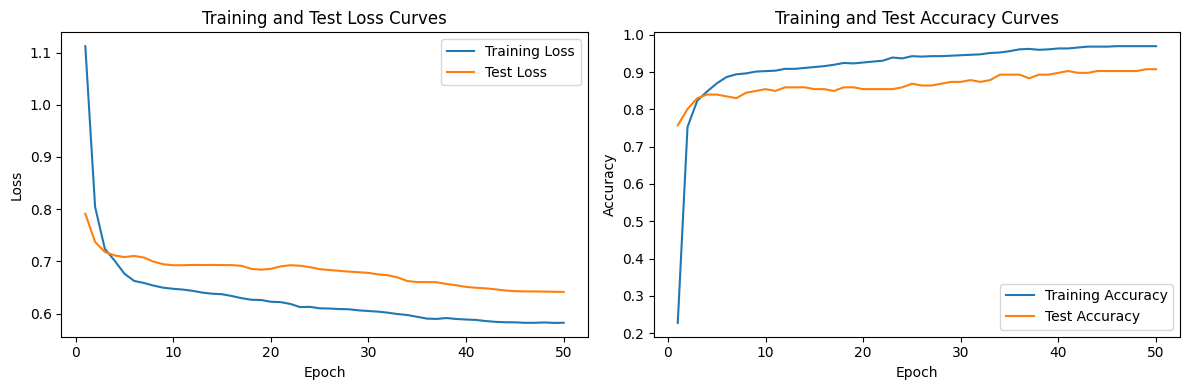

Training complete!


In [59]:
# Step 7: Training the Neural Network with Test Printing
print("Step 7: Training the Neural Network with Test Printing")

def train_and_plot_model(EPOCHS, model, X_train, y_train, X_test, y_test, optimizer):
    # Initialize lists to store training and test metrics
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    # Training loop
    for epoch in range(EPOCHS):
        # Training
        model.train()  # Set the model to training mode
        optimizer.zero_grad()
        outputs = model(X_train)
        train_loss = loss_fn(outputs, y_train)
        train_loss.backward()
        optimizer.step()

        train_accuracy = accuracy_fn(y_train, outputs)

        # Testing
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            test_outputs = model(X_test)
            test_loss = loss_fn(test_outputs, y_test)
            test_accuracy = accuracy_fn(y_test, test_outputs)

        # Log metrics
        train_losses.append(train_loss.item())
        test_losses.append(test_loss.item())
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)


        # Print the training and testing information
        if epoch < 10 or (epoch+1) % 10 == 0:
            print(f'Epoch: {epoch+1} | Loss: {train_loss.item():.5f}, Acc: {train_accuracy * 100:.2f}% | Test Loss: {test_loss.item():.5f}, Test Acc: {test_accuracy * 100:.2f}%')
        
    return model, (train_losses, test_losses, train_accuracies, test_accuracies)

def plot_learning_curves(train_losses, test_losses, train_accuracies, test_accuracies):
    # Plot Learning Curves
    plt.figure(figsize=(12, 4))

    # Plot Loss Curves
    plt.subplot(1, 2, 1)
    plt.plot(range(1, EPOCHS + 1), train_losses, label='Training Loss')
    plt.plot(range(1, EPOCHS + 1), test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Test Loss Curves')

    # Plot Accuracy Curves
    plt.subplot(1, 2, 2)
    plt.plot(range(1, EPOCHS + 1), train_accuracies, label='Training Accuracy')
    plt.plot(range(1, EPOCHS + 1), test_accuracies, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Test Accuracy Curves')

    plt.tight_layout()
    plt.show()

    print("Training complete!")

model, loss_acc_4tuple = train_and_plot_model(EPOCHS, model, X_train, y_train, X_test, y_test, optimizer)

plot_learning_curves(*loss_acc_4tuple)

Epoch: 1 | Loss: 1.09361, Acc: 39.05% | Test Loss: 0.75796, Test Acc: 79.61%
Epoch: 2 | Loss: 0.71516, Acc: 84.18% | Test Loss: 0.69845, Test Acc: 84.95%
Epoch: 3 | Loss: 0.66989, Acc: 87.83% | Test Loss: 0.66819, Test Acc: 88.35%
Epoch: 4 | Loss: 0.64409, Acc: 90.51% | Test Loss: 0.65011, Test Acc: 90.78%
Epoch: 5 | Loss: 0.62020, Acc: 93.43% | Test Loss: 0.64701, Test Acc: 90.78%
Epoch: 6 | Loss: 0.61069, Acc: 93.67% | Test Loss: 0.64430, Test Acc: 90.78%
Epoch: 7 | Loss: 0.59822, Acc: 95.86% | Test Loss: 0.64234, Test Acc: 90.78%
Epoch: 8 | Loss: 0.59267, Acc: 96.23% | Test Loss: 0.64642, Test Acc: 89.81%
Epoch: 9 | Loss: 0.58967, Acc: 96.59% | Test Loss: 0.64672, Test Acc: 89.32%
Epoch: 10 | Loss: 0.58784, Acc: 96.47% | Test Loss: 0.64411, Test Acc: 89.32%
Epoch: 20 | Loss: 0.57602, Acc: 97.57% | Test Loss: 0.64219, Test Acc: 90.78%
Epoch: 30 | Loss: 0.57455, Acc: 97.69% | Test Loss: 0.63169, Test Acc: 92.23%
Epoch: 40 | Loss: 0.57453, Acc: 97.69% | Test Loss: 0.62665, Test Acc: 93

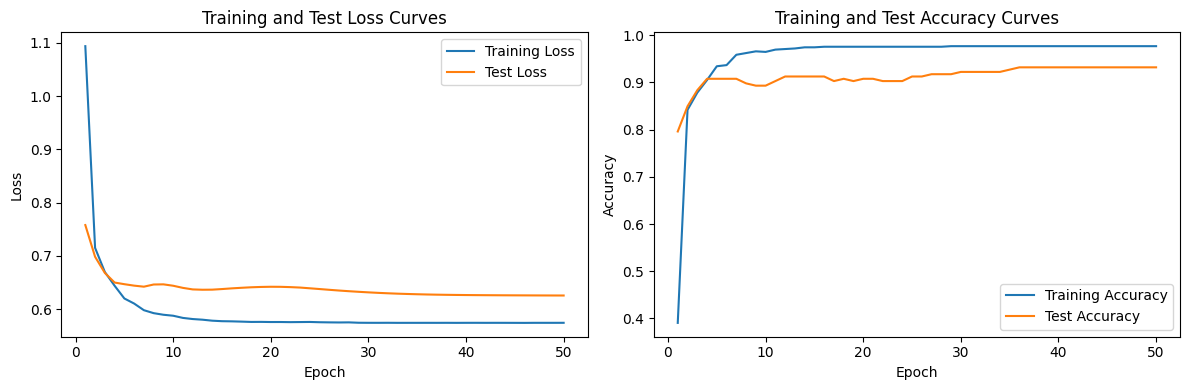

Training complete!
Test Accuracy: 93.20%
Class 0: Precision = 0.5882, Recall = 0.9091
Class 1: Precision = 0.9333, Recall = 0.9333
Class 2: Precision = 0.9767, Recall = 0.9333
Epoch: 1 | Loss: 1.07070, Acc: 45.86% | Test Loss: 0.73607, Test Acc: 81.07%
Epoch: 2 | Loss: 0.72097, Acc: 82.60% | Test Loss: 0.69441, Test Acc: 85.44%
Epoch: 3 | Loss: 0.68207, Acc: 86.74% | Test Loss: 0.66815, Test Acc: 87.86%
Epoch: 4 | Loss: 0.65776, Acc: 89.05% | Test Loss: 0.66620, Test Acc: 87.38%
Epoch: 5 | Loss: 0.64848, Acc: 90.27% | Test Loss: 0.66258, Test Acc: 88.83%
Epoch: 6 | Loss: 0.63681, Acc: 91.36% | Test Loss: 0.66592, Test Acc: 87.86%
Epoch: 7 | Loss: 0.62948, Acc: 92.34% | Test Loss: 0.66773, Test Acc: 87.86%
Epoch: 8 | Loss: 0.62681, Acc: 92.46% | Test Loss: 0.66482, Test Acc: 87.86%
Epoch: 9 | Loss: 0.62033, Acc: 93.19% | Test Loss: 0.65679, Test Acc: 89.32%
Epoch: 10 | Loss: 0.61376, Acc: 93.67% | Test Loss: 0.65248, Test Acc: 90.29%
Epoch: 20 | Loss: 0.58152, Acc: 96.96% | Test Loss: 0

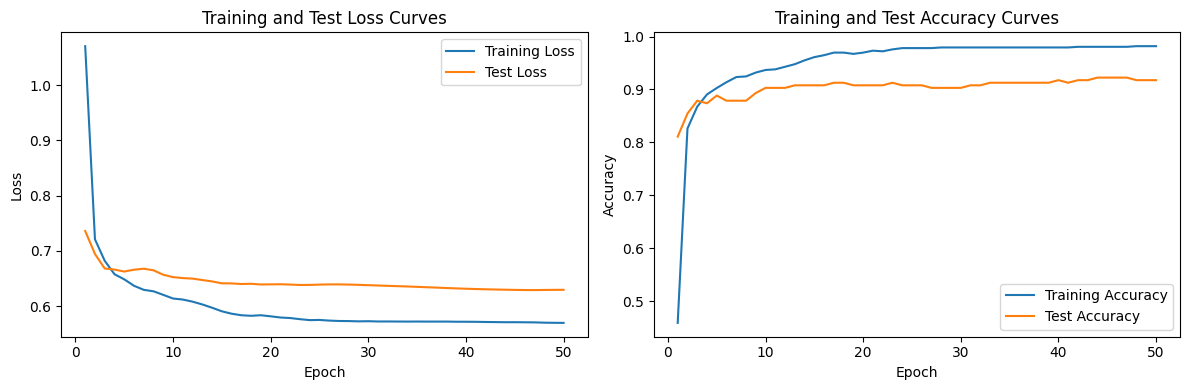

Training complete!
Test Accuracy: 91.75%
Class 0: Precision = 0.7778, Recall = 0.8750
Class 1: Precision = 0.9024, Recall = 0.9136
Class 2: Precision = 0.9528, Recall = 0.9266
Epoch: 1 | Loss: 1.12844, Acc: 25.67% | Test Loss: 0.75985, Test Acc: 79.61%
Epoch: 2 | Loss: 0.76667, Acc: 78.47% | Test Loss: 0.68514, Test Acc: 85.92%
Epoch: 3 | Loss: 0.70459, Acc: 84.31% | Test Loss: 0.67359, Test Acc: 87.38%
Epoch: 4 | Loss: 0.67951, Acc: 87.35% | Test Loss: 0.66580, Test Acc: 88.35%
Epoch: 5 | Loss: 0.66758, Acc: 88.20% | Test Loss: 0.65812, Test Acc: 89.81%
Epoch: 6 | Loss: 0.66024, Acc: 88.93% | Test Loss: 0.65808, Test Acc: 88.83%
Epoch: 7 | Loss: 0.65288, Acc: 89.54% | Test Loss: 0.65764, Test Acc: 88.83%
Epoch: 8 | Loss: 0.64586, Acc: 90.27% | Test Loss: 0.65829, Test Acc: 88.83%
Epoch: 9 | Loss: 0.64282, Acc: 90.75% | Test Loss: 0.65644, Test Acc: 88.83%
Epoch: 10 | Loss: 0.63925, Acc: 90.88% | Test Loss: 0.65112, Test Acc: 90.29%
Epoch: 20 | Loss: 0.61206, Acc: 93.92% | Test Loss: 0

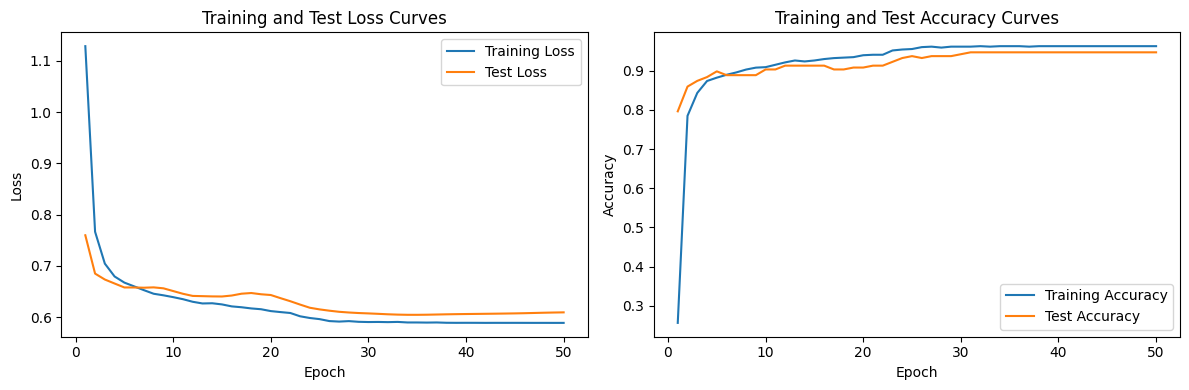

Training complete!
Test Accuracy: 94.66%
Class 0: Precision = 0.8000, Recall = 1.0000
Class 1: Precision = 0.9296, Recall = 0.9565
Class 2: Precision = 0.9826, Recall = 0.9339
Epoch: 1 | Loss: 1.12519, Acc: 26.76% | Test Loss: 0.80440, Test Acc: 74.27%
Epoch: 2 | Loss: 0.75398, Acc: 81.02% | Test Loss: 0.74490, Test Acc: 81.07%
Epoch: 3 | Loss: 0.68994, Acc: 85.89% | Test Loss: 0.72562, Test Acc: 81.55%
Epoch: 4 | Loss: 0.66308, Acc: 89.17% | Test Loss: 0.71703, Test Acc: 82.52%
Epoch: 5 | Loss: 0.65116, Acc: 90.02% | Test Loss: 0.71126, Test Acc: 82.52%
Epoch: 6 | Loss: 0.63869, Acc: 91.48% | Test Loss: 0.70464, Test Acc: 83.50%
Epoch: 7 | Loss: 0.62981, Acc: 91.97% | Test Loss: 0.69501, Test Acc: 85.44%
Epoch: 8 | Loss: 0.62045, Acc: 93.55% | Test Loss: 0.69079, Test Acc: 85.44%
Epoch: 9 | Loss: 0.62041, Acc: 93.19% | Test Loss: 0.68897, Test Acc: 85.44%
Epoch: 10 | Loss: 0.61801, Acc: 93.43% | Test Loss: 0.68836, Test Acc: 85.92%
Epoch: 20 | Loss: 0.58724, Acc: 96.47% | Test Loss: 0

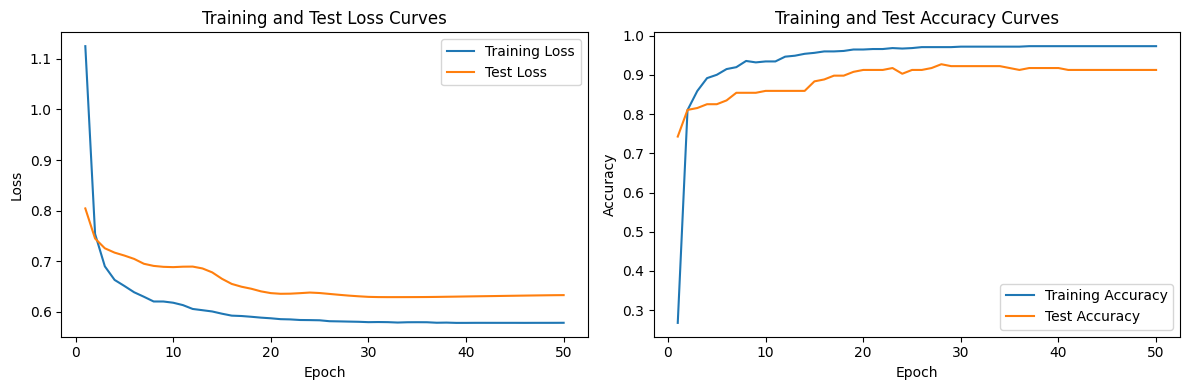

Training complete!
Test Accuracy: 91.26%
Class 0: Precision = 0.8000, Recall = 0.8000
Class 1: Precision = 0.8310, Recall = 0.9219
Class 2: Precision = 0.9750, Recall = 0.9213
Epoch: 1 | Loss: 1.11157, Acc: 25.06% | Test Loss: 0.77534, Test Acc: 78.64%
Epoch: 2 | Loss: 0.76460, Acc: 79.44% | Test Loss: 0.71405, Test Acc: 83.01%
Epoch: 3 | Loss: 0.71303, Acc: 83.09% | Test Loss: 0.70197, Test Acc: 83.98%
Epoch: 4 | Loss: 0.68950, Acc: 85.89% | Test Loss: 0.69025, Test Acc: 85.44%
Epoch: 5 | Loss: 0.67169, Acc: 87.47% | Test Loss: 0.68535, Test Acc: 86.41%
Epoch: 6 | Loss: 0.65198, Acc: 89.78% | Test Loss: 0.68541, Test Acc: 85.92%
Epoch: 7 | Loss: 0.64366, Acc: 90.63% | Test Loss: 0.69245, Test Acc: 84.95%
Epoch: 8 | Loss: 0.64225, Acc: 90.88% | Test Loss: 0.69692, Test Acc: 83.98%
Epoch: 9 | Loss: 0.64072, Acc: 91.00% | Test Loss: 0.69275, Test Acc: 84.95%
Epoch: 10 | Loss: 0.63657, Acc: 91.24% | Test Loss: 0.68448, Test Acc: 85.92%
Epoch: 20 | Loss: 0.60495, Acc: 94.65% | Test Loss: 0

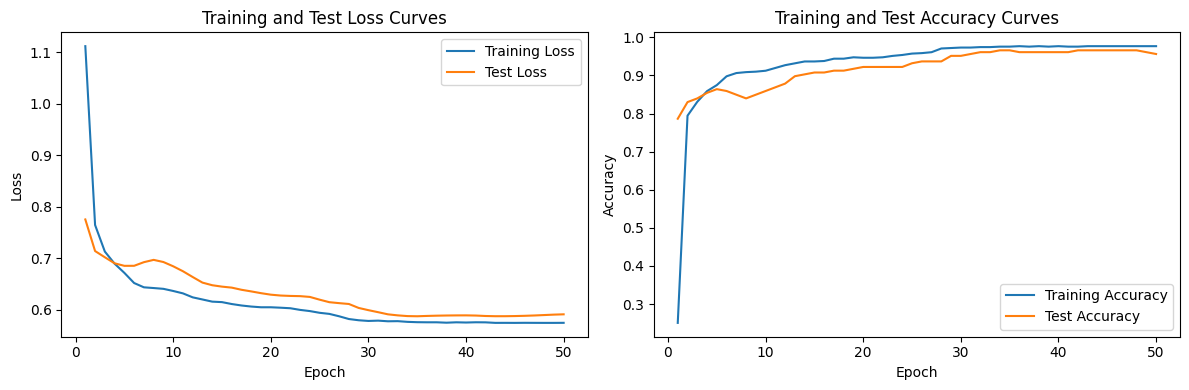

Training complete!
Test Accuracy: 95.63%
Class 0: Precision = 0.8667, Recall = 0.9286
Class 1: Precision = 0.9571, Recall = 0.9437
Class 2: Precision = 0.9669, Recall = 0.9669
Epoch: 1 | Loss: 1.10518, Acc: 32.00% | Test Loss: 0.74763, Test Acc: 80.58%
Epoch: 2 | Loss: 0.75407, Acc: 79.44% | Test Loss: 0.70355, Test Acc: 84.47%
Epoch: 3 | Loss: 0.70250, Acc: 84.31% | Test Loss: 0.69102, Test Acc: 85.44%
Epoch: 4 | Loss: 0.67277, Acc: 87.59% | Test Loss: 0.68865, Test Acc: 86.41%
Epoch: 5 | Loss: 0.65906, Acc: 89.29% | Test Loss: 0.68743, Test Acc: 85.44%
Epoch: 6 | Loss: 0.64914, Acc: 90.15% | Test Loss: 0.67063, Test Acc: 87.86%
Epoch: 7 | Loss: 0.64185, Acc: 90.88% | Test Loss: 0.65487, Test Acc: 89.81%
Epoch: 8 | Loss: 0.63607, Acc: 91.12% | Test Loss: 0.64720, Test Acc: 89.32%
Epoch: 9 | Loss: 0.63029, Acc: 92.09% | Test Loss: 0.64200, Test Acc: 90.78%
Epoch: 10 | Loss: 0.62925, Acc: 91.85% | Test Loss: 0.63976, Test Acc: 91.26%
Epoch: 20 | Loss: 0.58816, Acc: 96.35% | Test Loss: 0

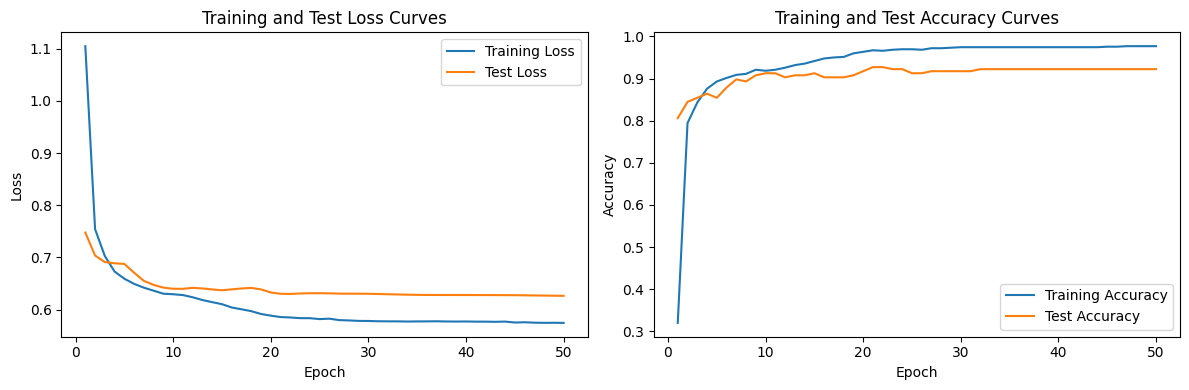

Training complete!
Test Accuracy: 92.23%
Class 0: Precision = 0.8095, Recall = 1.0000
Class 1: Precision = 0.8472, Recall = 0.9531
Class 2: Precision = 0.9912, Recall = 0.8960
Epoch: 1 | Loss: 1.10192, Acc: 30.54% | Test Loss: 0.73079, Test Acc: 82.52%
Epoch: 2 | Loss: 0.72764, Acc: 82.36% | Test Loss: 0.70393, Test Acc: 83.98%
Epoch: 3 | Loss: 0.68781, Acc: 85.89% | Test Loss: 0.67572, Test Acc: 87.38%
Epoch: 4 | Loss: 0.65557, Acc: 89.29% | Test Loss: 0.65886, Test Acc: 89.32%
Epoch: 5 | Loss: 0.63894, Acc: 91.24% | Test Loss: 0.66414, Test Acc: 87.86%
Epoch: 6 | Loss: 0.63221, Acc: 91.85% | Test Loss: 0.66913, Test Acc: 87.86%
Epoch: 7 | Loss: 0.62936, Acc: 92.34% | Test Loss: 0.67024, Test Acc: 87.38%
Epoch: 8 | Loss: 0.62583, Acc: 92.21% | Test Loss: 0.66737, Test Acc: 87.86%
Epoch: 9 | Loss: 0.61887, Acc: 93.07% | Test Loss: 0.66016, Test Acc: 88.83%
Epoch: 10 | Loss: 0.61240, Acc: 93.92% | Test Loss: 0.65210, Test Acc: 89.32%
Epoch: 20 | Loss: 0.58512, Acc: 96.72% | Test Loss: 0

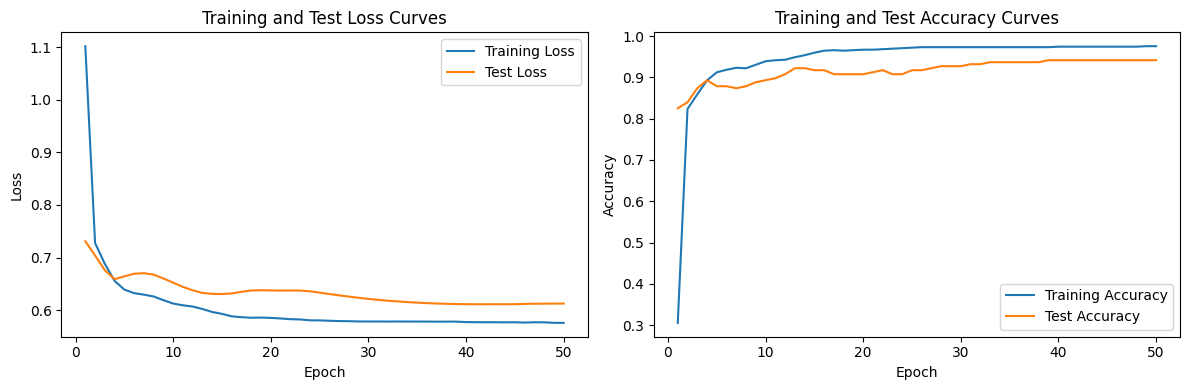

Training complete!
Test Accuracy: 94.17%
Class 0: Precision = 0.7059, Recall = 0.8000
Class 1: Precision = 0.9545, Recall = 0.9844
Class 2: Precision = 0.9675, Recall = 0.9370
Epoch: 1 | Loss: 1.10145, Acc: 34.91% | Test Loss: 0.87422, Test Acc: 66.02%
Epoch: 2 | Loss: 0.79867, Acc: 76.16% | Test Loss: 0.71405, Test Acc: 83.98%
Epoch: 3 | Loss: 0.69205, Acc: 85.16% | Test Loss: 0.68932, Test Acc: 85.92%
Epoch: 4 | Loss: 0.66604, Acc: 88.20% | Test Loss: 0.68956, Test Acc: 85.44%
Epoch: 5 | Loss: 0.65683, Acc: 89.17% | Test Loss: 0.68582, Test Acc: 85.44%
Epoch: 6 | Loss: 0.65209, Acc: 89.66% | Test Loss: 0.68080, Test Acc: 86.41%
Epoch: 7 | Loss: 0.64699, Acc: 90.27% | Test Loss: 0.67931, Test Acc: 86.89%
Epoch: 8 | Loss: 0.64145, Acc: 91.00% | Test Loss: 0.67804, Test Acc: 86.89%
Epoch: 9 | Loss: 0.63650, Acc: 91.61% | Test Loss: 0.67568, Test Acc: 86.89%
Epoch: 10 | Loss: 0.63262, Acc: 92.09% | Test Loss: 0.67240, Test Acc: 87.38%
Epoch: 20 | Loss: 0.60026, Acc: 95.01% | Test Loss: 0

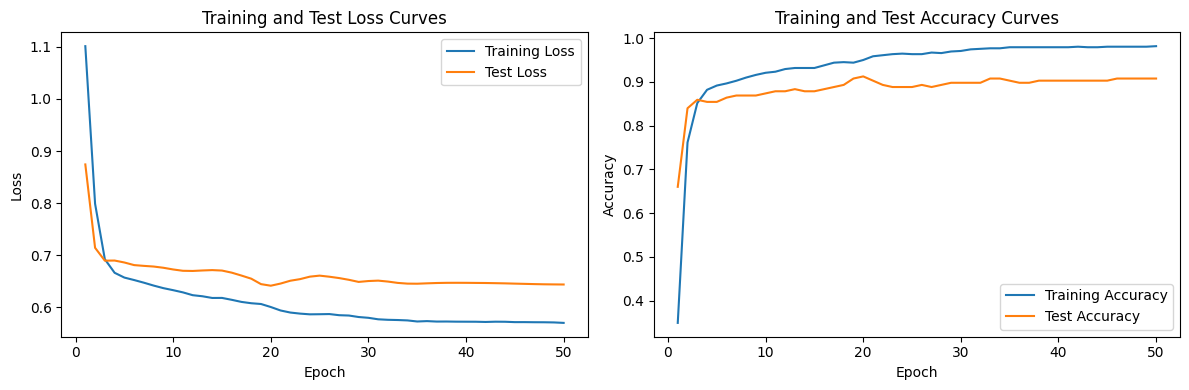

Training complete!
Test Accuracy: 90.78%
Class 0: Precision = 0.5455, Recall = 0.8000
Class 1: Precision = 0.9211, Recall = 0.8974
Class 2: Precision = 0.9722, Recall = 0.9292
Epoch: 1 | Loss: 1.12976, Acc: 18.13% | Test Loss: 0.80456, Test Acc: 75.73%
Epoch: 2 | Loss: 0.81790, Acc: 73.48% | Test Loss: 0.73078, Test Acc: 82.04%
Epoch: 3 | Loss: 0.71688, Acc: 83.70% | Test Loss: 0.71782, Test Acc: 82.52%
Epoch: 4 | Loss: 0.70633, Acc: 84.31% | Test Loss: 0.70166, Test Acc: 84.95%
Epoch: 5 | Loss: 0.68896, Acc: 85.77% | Test Loss: 0.69069, Test Acc: 85.44%
Epoch: 6 | Loss: 0.67593, Acc: 86.98% | Test Loss: 0.68345, Test Acc: 85.92%
Epoch: 7 | Loss: 0.66754, Acc: 88.08% | Test Loss: 0.68234, Test Acc: 86.41%
Epoch: 8 | Loss: 0.66500, Acc: 88.56% | Test Loss: 0.67983, Test Acc: 86.41%
Epoch: 9 | Loss: 0.66276, Acc: 88.44% | Test Loss: 0.67384, Test Acc: 86.89%
Epoch: 10 | Loss: 0.65726, Acc: 89.29% | Test Loss: 0.66795, Test Acc: 87.86%
Epoch: 20 | Loss: 0.62697, Acc: 92.34% | Test Loss: 0

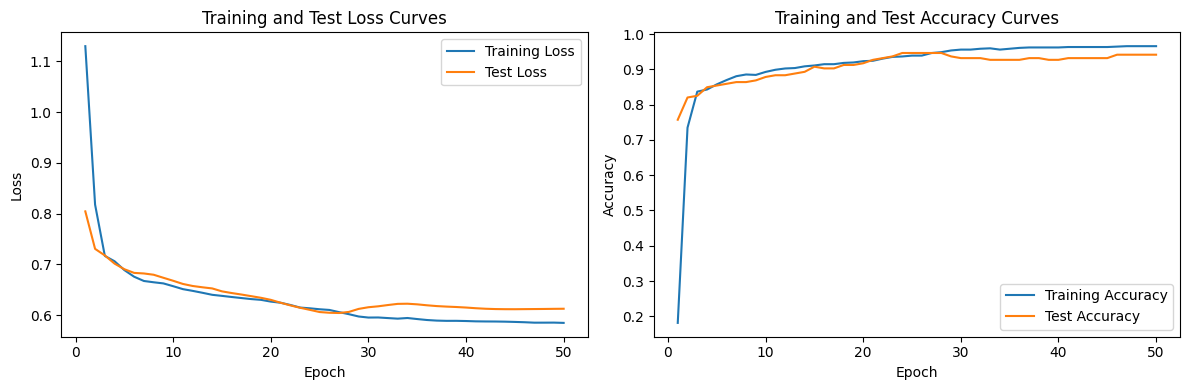

Training complete!
Test Accuracy: 94.17%
Class 0: Precision = 0.7308, Recall = 0.9500
Class 1: Precision = 0.9683, Recall = 0.9385
Class 2: Precision = 0.9744, Recall = 0.9421
Epoch: 1 | Loss: 1.08402, Acc: 38.93% | Test Loss: 0.76736, Test Acc: 77.18%
Epoch: 2 | Loss: 0.78877, Acc: 75.67% | Test Loss: 0.67543, Test Acc: 86.89%
Epoch: 3 | Loss: 0.71152, Acc: 83.70% | Test Loss: 0.65746, Test Acc: 88.83%
Epoch: 4 | Loss: 0.68435, Acc: 86.13% | Test Loss: 0.65198, Test Acc: 88.83%
Epoch: 5 | Loss: 0.66389, Acc: 88.44% | Test Loss: 0.64230, Test Acc: 90.78%
Epoch: 6 | Loss: 0.64819, Acc: 89.78% | Test Loss: 0.63597, Test Acc: 92.23%
Epoch: 7 | Loss: 0.63420, Acc: 91.85% | Test Loss: 0.63696, Test Acc: 91.26%
Epoch: 8 | Loss: 0.62539, Acc: 92.58% | Test Loss: 0.63250, Test Acc: 91.75%
Epoch: 9 | Loss: 0.61931, Acc: 93.07% | Test Loss: 0.62485, Test Acc: 92.72%
Epoch: 10 | Loss: 0.61299, Acc: 93.80% | Test Loss: 0.61633, Test Acc: 93.20%
Epoch: 20 | Loss: 0.58285, Acc: 96.96% | Test Loss: 0

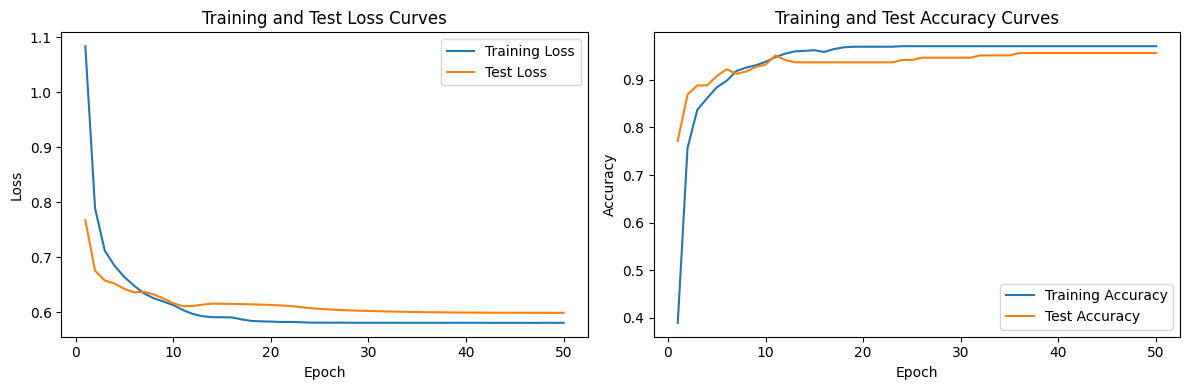

Training complete!
Test Accuracy: 95.63%
Class 0: Precision = 0.8261, Recall = 0.9048
Class 1: Precision = 0.9538, Recall = 0.9688
Class 2: Precision = 0.9831, Recall = 0.9587


In [66]:
def execute_model_training(data, HIDDEN_UNITS, NUM_FEATURES, NUM_CLASSES, LR, EPOCHS, SEED, loss_fn):
    # Step 2 Splitting data & formatting to tensor
    X_train, X_test, y_train, y_test = split_data(data, normalize=True, seed=SEED)
    
    # Step 5: Initialize the Neural Network
    model = SimpleClassifier(NUM_FEATURES, HIDDEN_UNITS, NUM_CLASSES)

    # Step 6: Define Optimizer
    optimizer = optim.Adam(model.parameters(), lr=LR)

    # Step 7: Training the Neural Network with Test Printing
    model, loss_acc_4tuple = train_and_plot_model(EPOCHS, model, X_train, y_train, X_test, y_test, optimizer)

    plot_learning_curves(*loss_acc_4tuple)

    return model, X_test, y_test



#### test series

acc_list = []

# Step 1 Loading data if necessary
try:
    data                 # its ok that this var is not defined 
except NameError:
    data = load_data(0)

for i in range(10):
    model, X_test, y_test = execute_model_training(
        data,
        HIDDEN_UNITS, 
        NUM_FEATURES, 
        NUM_CLASSES, 
        LR, 
        EPOCHS, 
        SEED, 
        loss_fn)

    # Evaluation (Forward pass) on the test set
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        outputs = model(X_test)
        _, predicted = torch.max(outputs, 1)

    # Calculate accuracy
    correct = (predicted == y_test).sum().item()
    total = y_test.size(0)
    test_accuracy = correct / total

    print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
    acc_list.append(test_accuracy)

    # Calculate Precision and Recall
    precision = precision_score(y_test, predicted, average=None)
    recall = recall_score(y_test, predicted, average=None)

    # Print Precision and Recall for each class
    for i, (prec, rec) in enumerate(zip(precision, recall)):
        print(f'Class {i}: Precision = {prec:.4f}, Recall = {rec:.4f}')
    print()


[0.9320388349514563, 0.9174757281553398, 0.9466019417475728, 0.912621359223301, 0.9563106796116505, 0.9223300970873787, 0.941747572815534, 0.9077669902912622, 0.941747572815534, 0.9563106796116505]
0.933495145631068


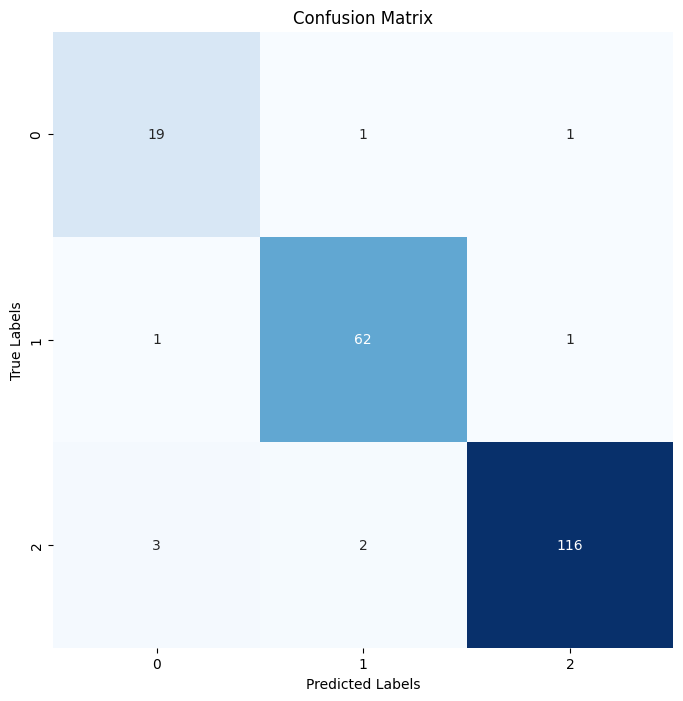

In [67]:
from statistics import mean 

print(acc_list)
print(mean(acc_list))


conf_matrix = confusion_matrix(y_test, predicted)
# Visualize Confusion Matrix
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [68]:
# Convert the test data to PyTorch tensors
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

# Evaluation (Forward pass) on the test set
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    outputs = model(X_test)
    _, predicted = torch.max(outputs, 1)

# Calculate accuracy
correct = (predicted == y_test).sum().item()
total = y_test.size(0)
test_accuracy = correct / total

print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

Test Accuracy: 95.63%


C:\Users\meike\AppData\Local\Temp\ipykernel_3392\2488856709.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, dtype=torch.float32)
C:\Users\meike\AppData\Local\Temp\ipykernel_3392\2488856709.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.long)


Weighted F1 Score on Test Set: 0.9569


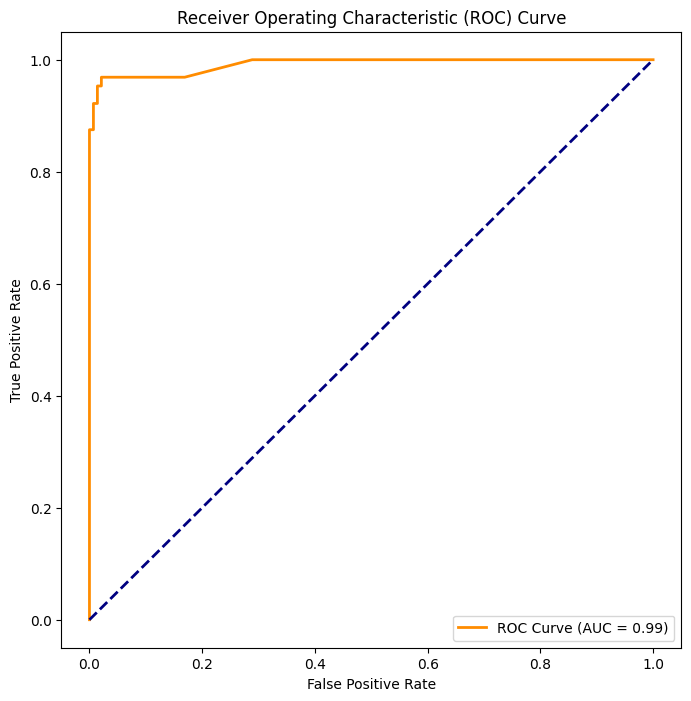

In [69]:

model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    _, predicted_labels = torch.max(test_outputs, 1)

f1 = f1_score(y_test, predicted_labels, average='weighted')
print(f'Weighted F1 Score on Test Set: {f1:.4f}')

# Plot ROC Curve
probs = torch.nn.functional.softmax(test_outputs, dim=1).numpy()
fpr, tpr, thresholds = roc_curve(y_test, probs[:, 1], pos_label=1)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [70]:

# Calculate Precision and Recall
precision = precision_score(y_test, predicted_labels, average=None)
recall = recall_score(y_test, predicted_labels, average=None)

# Print Precision and Recall for each class
for i, (prec, rec) in enumerate(zip(precision, recall)):
    print(f'Class {i}: Precision = {prec:.4f}, Recall = {rec:.4f}')


Class 0: Precision = 0.8261, Recall = 0.9048
Class 1: Precision = 0.9538, Recall = 0.9688
Class 2: Precision = 0.9831, Recall = 0.9587


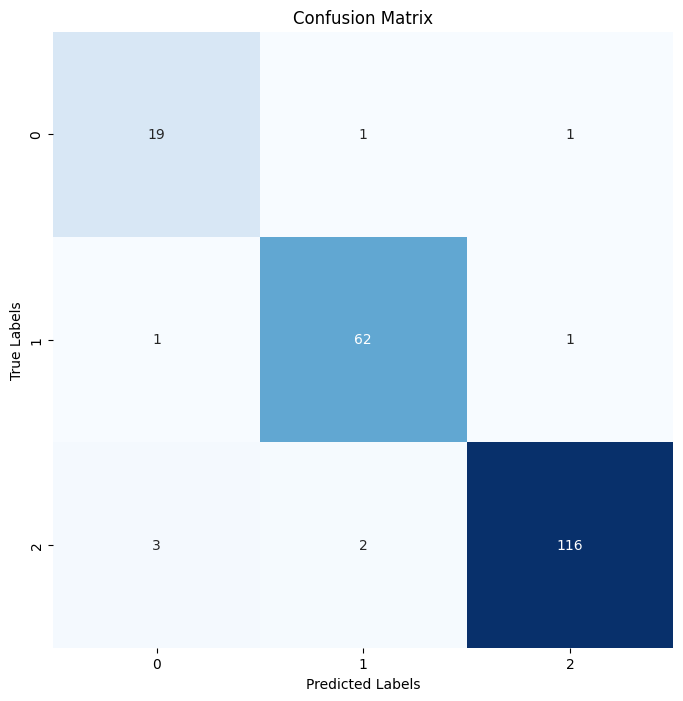

In [71]:

conf_matrix = confusion_matrix(y_test, predicted_labels)
# Visualize Confusion Matrix
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
